# **Expedia expected experience**
### *Machine Learning* - a.y. 2020/2021 - Final Project
### *Authors:* Emanuele Mercanti 1719869 , Andrea Trianni 1806198
___


## 0.0 - Environment Setup

In [ ]:
# Setup Drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ml_final_project

Mounted at /content/drive
/content/drive/MyDrive/ml_final_project


In [ ]:
# install
!pip install shap -q
!pip install category_encoders -q

     |████████████████████████████████| 327kB 5.5MB/s 
     |████████████████████████████████| 81kB 3.7MB/s 


In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import shap
from datetime import datetime

from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, classification_report
from scipy.spatial.distance import jensenshannon

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import tensorflow.keras as keras

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Path Declaration
DATA_PATH = './data/train.csv'

In [ ]:
# data loading 
df = pd.read_csv(DATA_PATH, nrows = 150000)

# get target from checkin-checkout
stay = pd.to_datetime(df.srch_co) - pd.to_datetime(df.srch_ci)
#drop nan target
stay = stay.apply(lambda x: x.days if x.days > 0 else np.nan).dropna()
# cap at 15
stay = stay.apply(lambda x: x if x < 15 else 15)
# keep only data corresponding to non null targets
df = df.loc[stay.index]
# drop check in aqnd check out
df.drop(columns =['srch_co'], inplace = True )
# keep check in month
df['srch_ci'] = pd.to_datetime(df.srch_ci).apply(lambda x: x.month)


# test set
df, x_test, stay, y_test = train_test_split(df, 
                                           stay, 
                                           stratify = stay,
                                           test_size = 0.33, 
                                           random_state = 404)

# target
df['stay'] = stay

## 1.0 - Data exploration

In [ ]:
display(df.head(5))

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,stay
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,8,2,0,1,8250,1,0,3,2,50,628,1,4.0
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,8,2,0,1,8250,1,1,1,2,50,628,1,4.0
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,8,2,0,1,8250,1,0,1,2,50,628,1,4.0
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,3,11,2,0,1,14984,1,0,1,2,50,1457,80,5.0
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,3,11,2,0,1,14984,1,0,1,2,50,1457,21,5.0


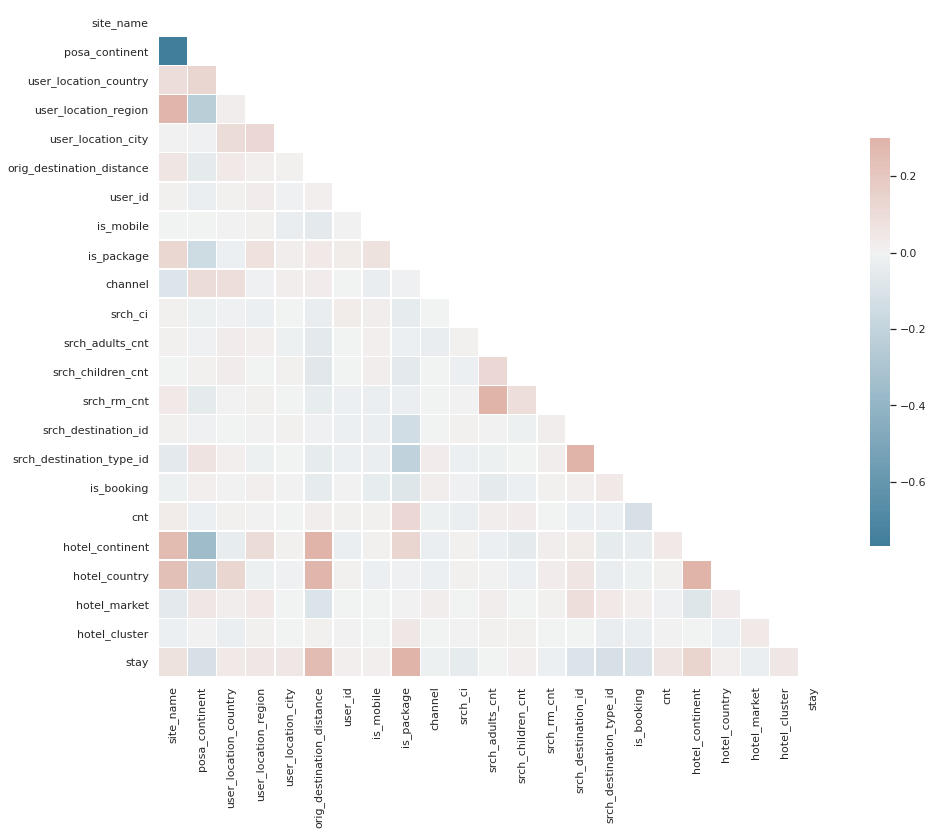

In [ ]:
# check correlations with target


sns.set_theme(style="white")

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            annot = False, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

plt.show()
f.savefig('./plots/all_correlation.png')

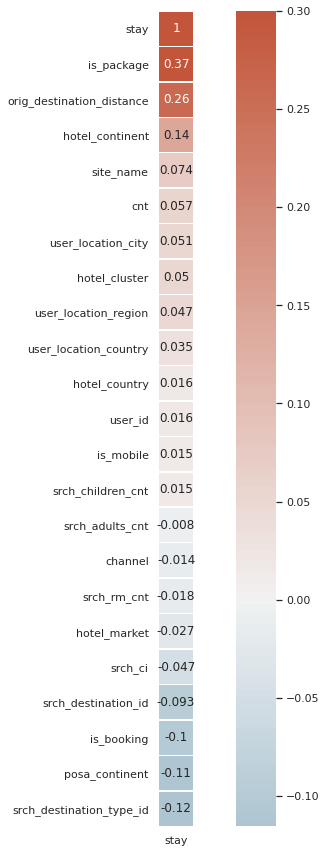

In [ ]:
sns.set_theme(style="white")

corr = df.corr()[['stay']].sort_values(by = 'stay', ascending = False)
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            annot = True, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5)
plt.show()
f.savefig('./plots/stay_correlation.png')

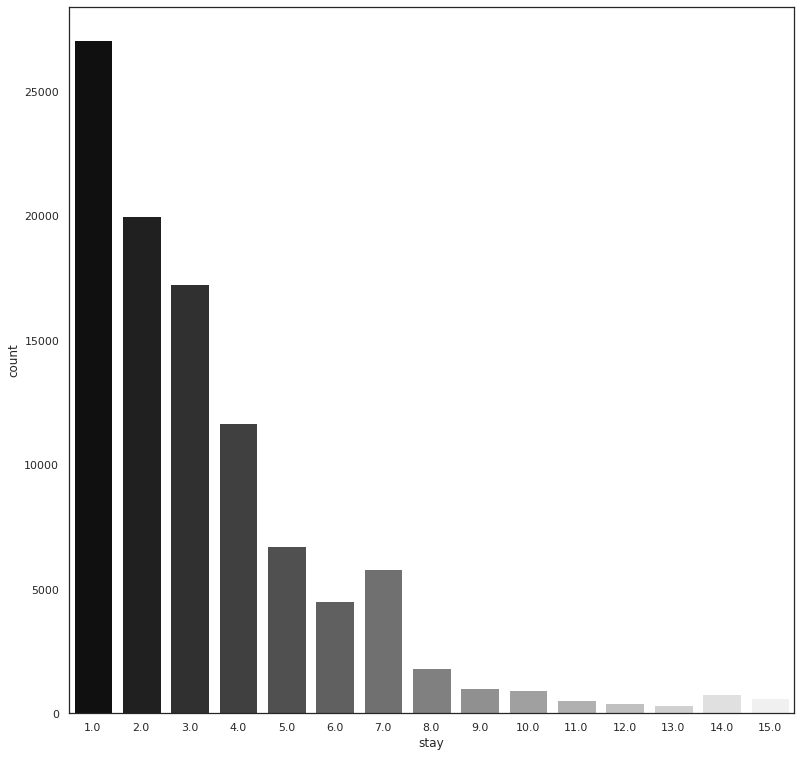

In [ ]:
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(13, 13))
sns.countplot(df.stay, palette = 'gray')

plt.show()
f.savefig('./plots/stay_countplot.png')

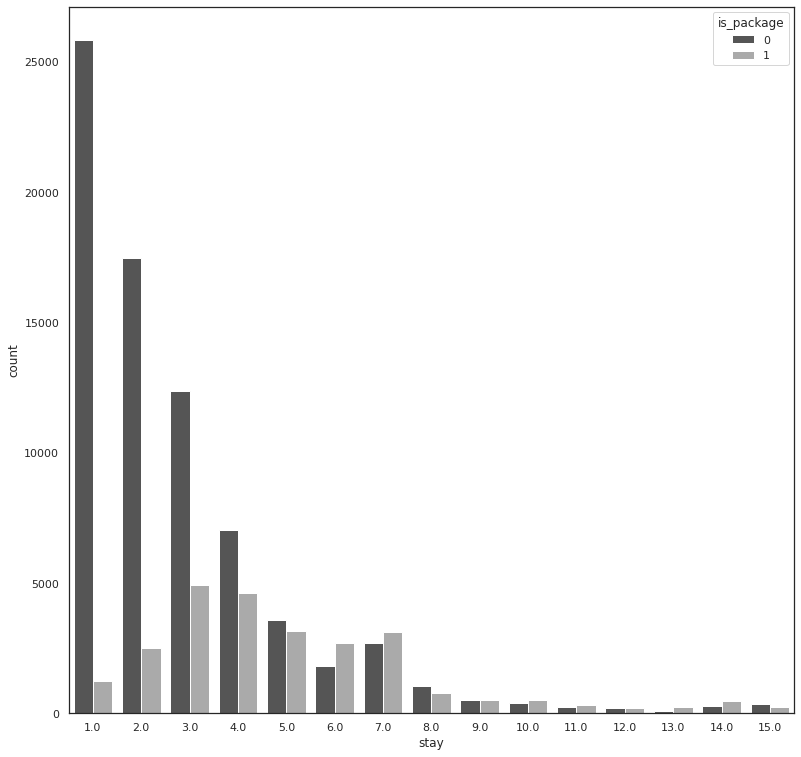

In [ ]:
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)
sns.countplot(df.stay, hue = df['is_package'], palette = 'gray' )
plt.show()
f.savefig('./plots/stay_hue_is_package_countplot.png')

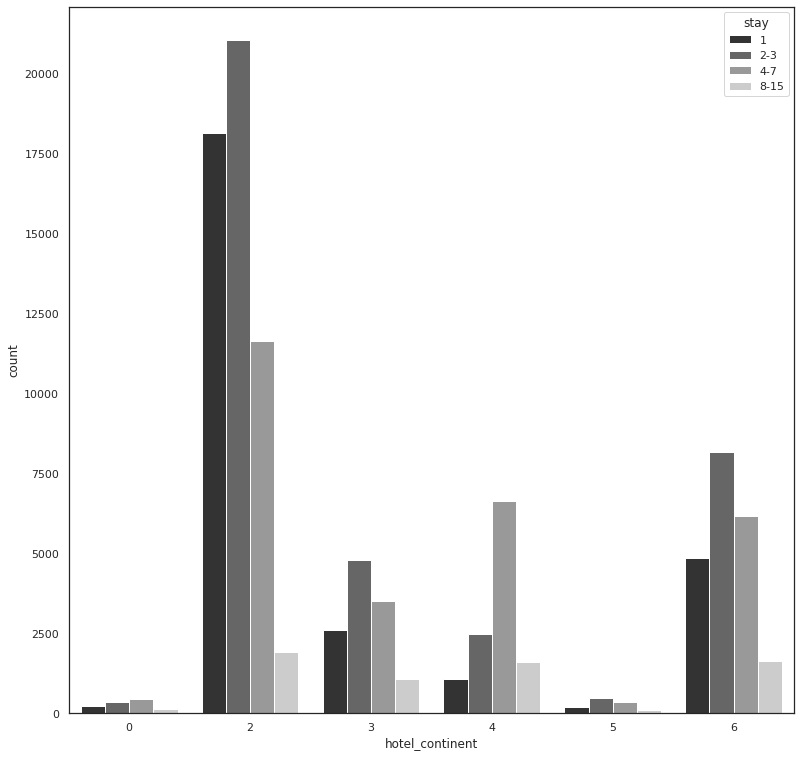

In [ ]:
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)
sns.countplot(df['hotel_continent'], 
              hue = df['stay'].sort_values().apply(lambda x: 1 if x == 1 else '2-3' if x <=3 else '4-7' if x<=7 else '8-15'), 
              palette = 'gray')

plt.show()

f.savefig('./plots/hotel_continent_vs_stay_countplot.png')

No handles with labels found to put in legend.


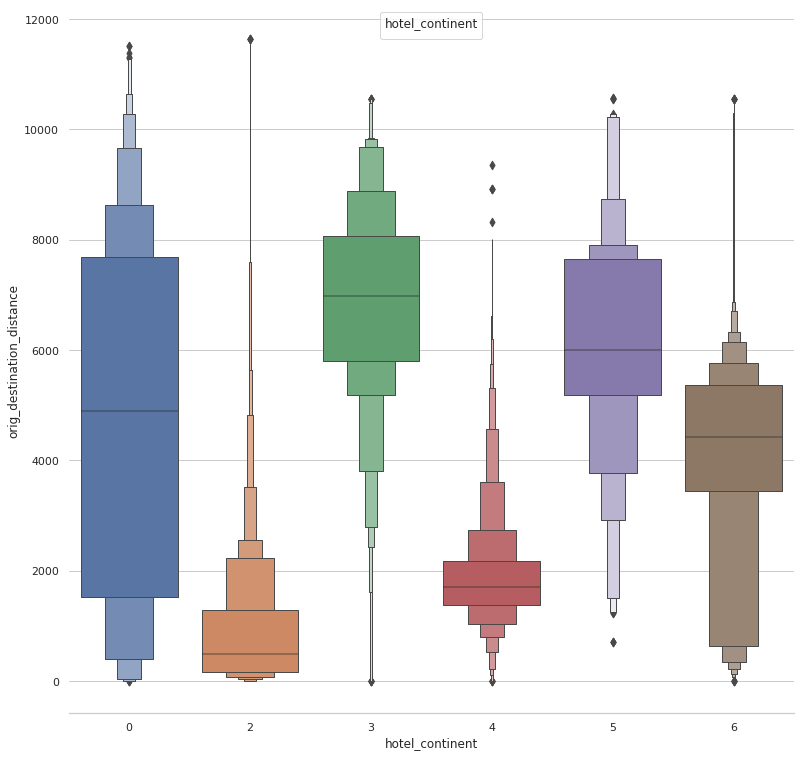

In [ ]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)

x = df['stay'].sort_values().apply(lambda x: 1 if x == 1 else '2-3' if x <=3 else '4-7' if x<=7 else '8-15')

sns.boxenplot(data=df, 
               x = df['hotel_continent'], 
               y=df['orig_destination_distance'],
               linewidth=1)
sns.despine(left=True)
plt.legend(loc = 'upper center', title= 'hotel_continent')
plt.show()

f.savefig('./plots/hotel_continent_vs_orig_distance_distribution_boxenplot.png')

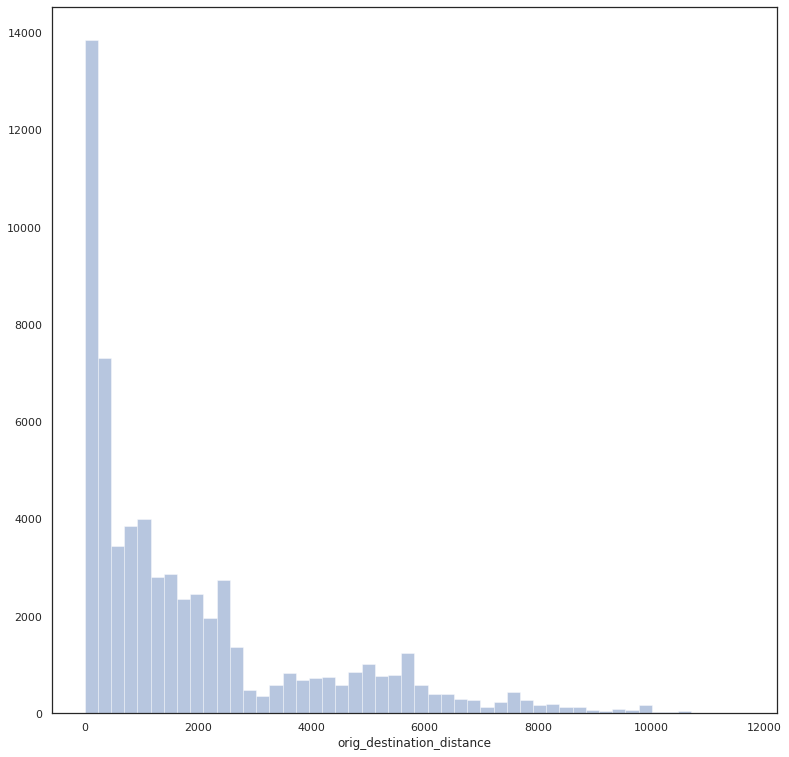

In [ ]:
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)
sns.distplot(df['orig_destination_distance'].dropna(), kde = False)
plt.show()
f.savefig('./plots/orig_destination_distance_distribution.png')

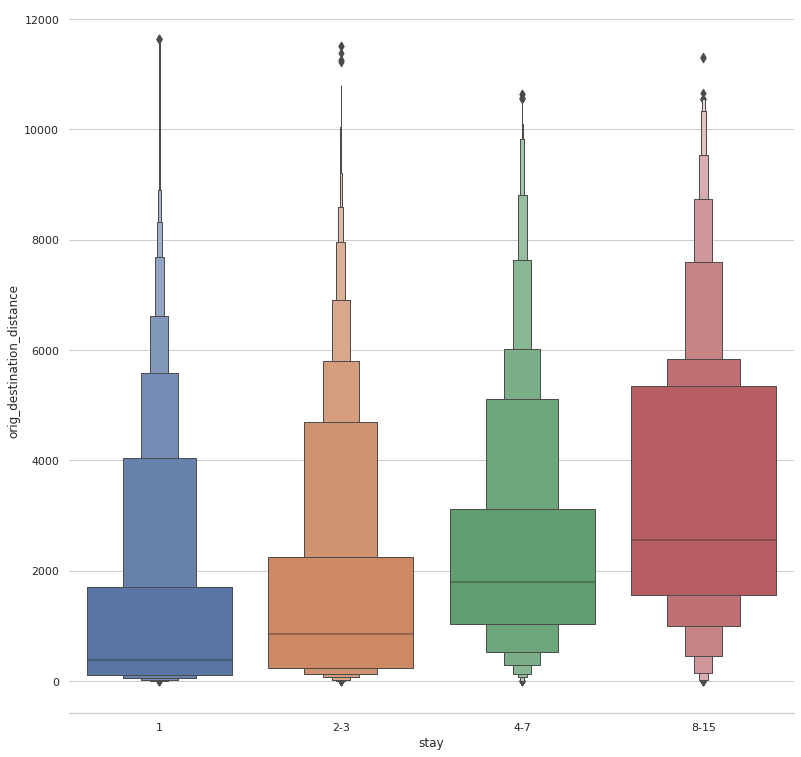

In [ ]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)

x = df['stay'].sort_values().apply(lambda x: 1 if x == 1 else '2-3' if x <=3 else '4-7' if x<=7 else '8-15')

sns.boxenplot(data=df, 
               x = x, 
               y=df['orig_destination_distance'],
               linewidth=1)
sns.despine(left=True)
plt.show()

f.savefig("./plots/stay_vs_origDestination_segmented.png")

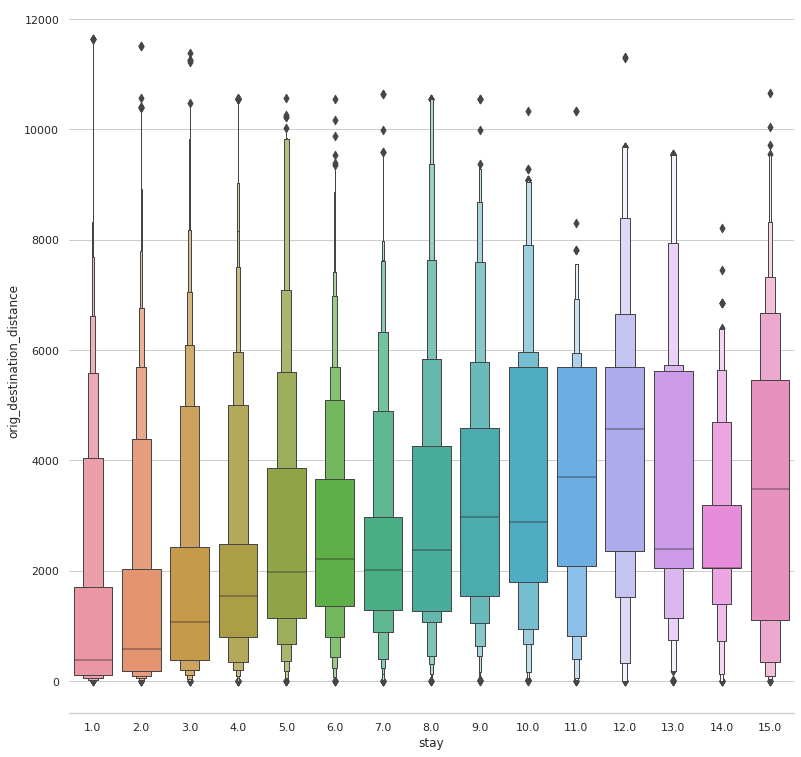

In [ ]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)

x = df['stay'].sort_values()

sns.boxenplot(data=df, 
               x = x, 
               y=df['orig_destination_distance'],
               linewidth=1)
sns.despine(left=True)
plt.show()

f.savefig("./plots/stay_vs_origDestination.png")

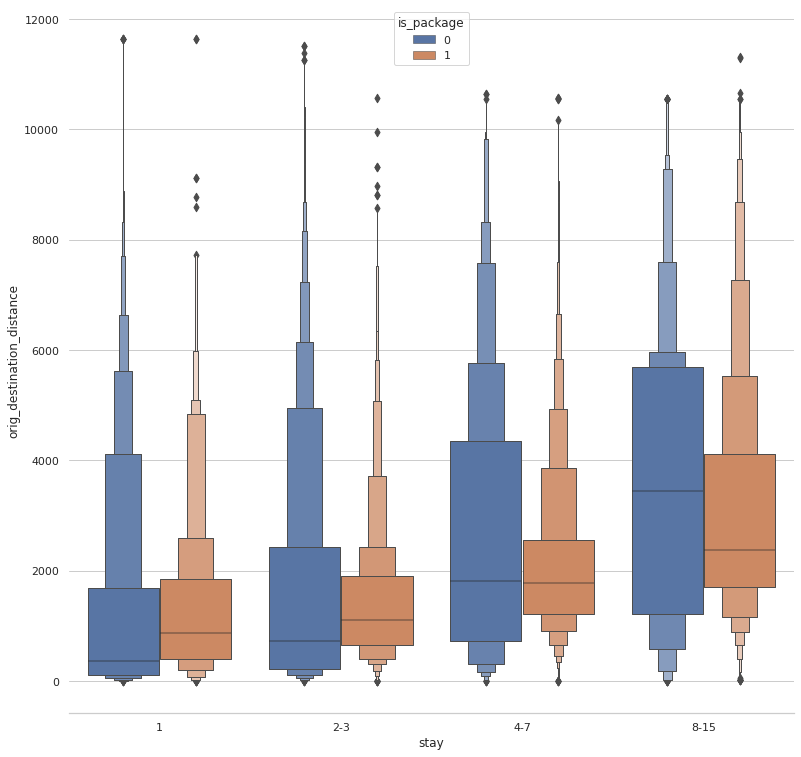

In [ ]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)

x = df['stay'].sort_values().apply(lambda x: 1 if x == 1 else '2-3' if x <=3 else '4-7' if x<=7 else '8-15')

sns.boxenplot(data=df, 
               x = x, 
               y=df['orig_destination_distance'],
               hue = df['is_package'],
               linewidth=1)
sns.despine(left=True)
plt.legend(loc = 'upper center', title= 'is_package')
plt.show()

f.savefig("./plots/stay_vs_origDestination_hue_is_package_boxenplot.png")

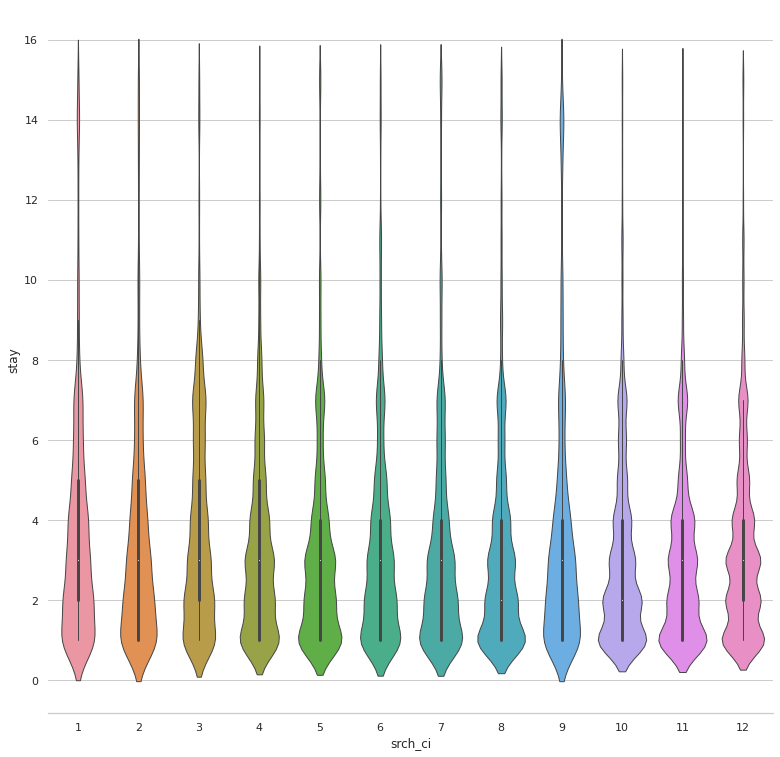

In [ ]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=False)


sns.violinplot(data=df, 
              x=df['srch_ci'],
               y = df['stay'], 
               linewidth=1)
sns.despine(left=True)
plt.show()
f.savefig('./plots/srch_ci_vs_stay_violinplot.png')

## 2.0 - Feature Engineering


2.2 Preprocess

In [ ]:
df.info()
df.drop(columns = 'date_time', inplace = True)
y_target = df.pop('stay')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100008 entries, 97588 to 113107
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100008 non-null  object 
 1   site_name                  100008 non-null  int64  
 2   posa_continent             100008 non-null  int64  
 3   user_location_country      100008 non-null  int64  
 4   user_location_region       100008 non-null  int64  
 5   user_location_city         100008 non-null  int64  
 6   orig_destination_distance  65061 non-null   float64
 7   user_id                    100008 non-null  int64  
 8   is_mobile                  100008 non-null  int64  
 9   is_package                 100008 non-null  int64  
 10  channel                    100008 non-null  int64  
 11  srch_ci                    100008 non-null  int64  
 12  srch_adults_cnt            100008 non-null  int64  
 13  srch_children_cnt        

In [ ]:
def KNN_impute(train, test, n_neighbors = 3):

  train_index = train.index
  test_index = test.index
  cols = train.columns

  imputer = KNNImputer(n_neighbors = n_neighbors)
  imputer.fit(train)
  train = imputer.transform(train)

  test = imputer.transform(test)

  return pd.DataFrame(train, columns = cols, index = train_index), pd.DataFrame(test, columns = cols, index = test_index)

def encode_looe(x_train, x_test, y_train):

  looe_cols = ['site_name', 'user_location_country', 'user_location_region', \
               'user_location_city', 'user_id', 'srch_destination_id', 'hotel_country', \
               'hotel_market', 'hotel_cluster']

  train_index = x_train.index
  test_index = x_test.index
  cols = x_train.columns

  looe = ce.LeaveOneOutEncoder(cols = looe_cols)
  looe.fit(x_train, y_train)
  x_train = looe.transform(x_train)

  x_test = looe.transform(x_test)

  return x_train, x_test


def encode_ohe(x_train, x_test):

  ohe_cols = ['posa_continent', 'channel', 'srch_destination_type_id', 'hotel_continent']

  train_index = x_train.index
  test_index = x_test.index
  cols = x_train.columns

  ohe = OneHotEncoder(handle_unknown = 'ignore')
  ohe.fit(x_train[ohe_cols])
  new_cols = [col + '_' + str(int(i)) for col in ohe_cols for i in x_train[col].unique()]
  train_temp = ohe.transform(x_train[ohe_cols]).toarray()
  
  x_train[new_cols] = train_temp

  test_temp = ohe.transform(x_test[ohe_cols]).toarray()
  
  x_test[new_cols] = test_temp

  return x_train.drop(columns = ohe_cols), x_test.drop(columns = ohe_cols)

def scale(x_train, x_test):

  train_index = x_train.index
  test_index = x_test.index
  cols = x_train.columns

  scale_cols = ['orig_destination_distance']

  scaler = StandardScaler()
  scaler.fit(x_train[scale_cols])
  x_train[scale_cols] = scaler.transform(x_train[scale_cols])

  x_test[scale_cols] = scaler.transform(x_test[scale_cols])

  return x_train, x_test


def preprocess(x_train, x_test, y_train):
   x_train, x_test = KNN_impute(x_train, x_test)
   x_train, x_test = encode_looe(x_train, x_test, y_train)
   x_train, x_test = encode_ohe(x_train, x_test)
   x_train, x_test = scale(x_train, x_test)
   return x_train, x_test

2.2 Classes balancement

In [ ]:
# train, dev set
x_train, x_dev, y_train, y_dev = train_test_split(df, 
                                                  y_target, 
                                                  test_size = 0.15, 
                                                  stratify = y_target, 
                                                  random_state = 404)

# needed for explanability
x_train_shap = x_train.copy()
y_train_shap = y_train.copy()

# class weightes for mlp
cw = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
cw = dict(zip([i for i in range(15)], cw))

## 3.0 - Model Selection

### 3.1 crossval

In [ ]:
def kf_cross_val(model, data, target, n_splits = 5):
  scores = []
  kf = StratifiedKFold(n_splits)
  fold = 0
  for train_index, test_index in kf.split(data, target):
    #  t = datetime.now()
     print('Working on fold', fold)
     x_train, x_test = data.iloc[train_index], data.iloc[test_index]
     y_train, y_test = target.iloc[train_index], target.iloc[test_index]
     x_train, x_test = preprocess(x_train, x_test, y_train)
     model.fit(x_train, y_train)
     y_pred = model.predict(x_test)
     scores.append(f1_score(y_test, y_pred, average='weighted'))
     fold += 1
    #  print(datetime.now() - t)
    #  print(scores[-1])
  return np.array(scores)

####  Decision Tree

In [ ]:
tree_clf = DecisionTreeClassifier(class_weight='balanced')
tree_scores = kf_cross_val(tree_clf, x_train, y_train)
print(tree_scores, "\n MEAN:",tree_scores.mean(), "\n MAX: " ,  tree_scores.max())

Working on fold 0
Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
[0.67958097 0.68184624 0.67666348 0.68323581 0.68238109] 
 MEAN: 0.6807415188825783 
 MAX:  0.683235805876653


#### Random Forest

In [ ]:
forest_clf = RandomForestClassifier(class_weight="balanced")
forest_scores = kf_cross_val(forest_clf, x_train, y_train)
print(forest_scores, "\n MEAN:",forest_scores.mean(), "\n MAX: " ,  forest_scores.max())

Working on fold 0
Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
[0.74288158 0.74633753 0.73479504 0.74843755 0.7409512 ] 
 MEAN: 0.7426805796395034 
 MAX:  0.7484375495140656


####  K Nearest Neighbor

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_scores = kf_cross_val(knn_clf, x_train, y_train)
print(knn_scores, "\n MEAN:",knn_scores.mean(), "\n MAX: " ,  knn_scores.max())

Working on fold 0
Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
[0.58449876 0.57975383 0.56759741 0.57411432 0.57730325] 
 MEAN: 0.5766535135387922 
 MAX:  0.5844987608536245


####  Support vector machines

In [ ]:
svm_clf = SVC(kernel='rbf', class_weight='balanced')
svm_scores = kf_cross_val(svm_clf, x_train, y_train)
print(svm_scores, "\n MEAN:",svm_scores.mean(), "\n MAX: " ,  svm_scores.max())

Working on fold 0
Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
[0.38387473 0.39005625 0.39285748 0.39478758 0.38551226] 
 MEAN: 0.3894176595644888 
 MAX:  0.3947875763250822


####  MLP

In [ ]:
input_units = len(x_train.columns)
output_units = len(y_train.unique()) 
mlp_clf = keras.Sequential([                          
                  keras.layers.Dense(units = input_units, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
                  keras.layers.Dropout(0.25),
                  keras.layers.Dense(units = input_units, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
                  keras.layers.Dropout(0.25), 
                  keras.layers.Dense(units = input_units//2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
                  keras.layers.Dropout(0.25), 
                  keras.layers.Dense(units = output_units, activation="softmax")])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto')
mlp_clf.compile(optimizer= optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
mlp_x_train, mlp_x_dev = preprocess(x_train, x_dev, y_train)
mlp_clf.fit(mlp_x_train, y_train.apply(lambda y: y-1), validation_data = (mlp_x_dev, y_dev.apply(lambda y: y-1)), epochs=200, batch_size=16,callbacks=[callback], verbose = 1, class_weight = cw)

In [ ]:
print('f1-score is',f1_score(y_true = y_dev.apply(lambda x: x-1), y_pred = np.argmax(mlp_clf.predict(mlp_x_dev),axis=1), average='weighted'))


f1-score is 0.3442731140945975


### 3.2  learning curve

In [ ]:
# Parameters
models = [ mlp_clf, tree_clf, svm_clf, knn_clf, forest_clf ]
sizes  = [0.1, 0.3, 0.5, 0.7, 0.9]
train_sizes = [int (size * len(y_train)) for size in sizes]
names  = [ "mlp", "tree", "svm", "knn", "forest"]


def train_multiple_sizes(x_train, y_train, x_dev, y_dev, models, model_names, sizes):
  x_train = shuffle(x_train, random_state = 404)
  y_train = shuffle(y_train, random_state = 404)
  # x_train, x_dev = preprocess(x_train, x_dev, y_train)


  train_sizes = [int(size * len(y_train)) for size in sizes]

  all_scores = pd.DataFrame(columns = ['model', 'train_size', 'score'])
  
  for name, model in zip(model_names, models):
    print('working on model:', name)
    for size in train_sizes:
      x_train_mlp = x_train.iloc[: size]
      y_train_mlp = y_train.iloc[: size]
      if name == 'mlp': 
        mlp_clf.compile(optimizer= optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        mlp_clf.fit(x_train_mlp, y_train_mlp-1, validation_data = (x_dev, y_dev -1), epochs=200, batch_size=16, callbacks=[callback], verbose = 0, class_weight = cw)      
        prediction = np.argmax(mlp_clf.predict(x_dev), axis=1)
        score = f1_score(y_dev-1, prediction, average='weighted')
        all_scores = all_scores.append({'model': name, 'train_size': size, 'score': score}, ignore_index = True)

      else:

        model.fit(x_train.iloc[: size], y_train.iloc[: size])
        prediction = model.predict(x_dev)
        score = f1_score(y_dev, prediction, average='weighted')
        all_scores = all_scores.append({'model': name, 'train_size': size, 'score': score}, ignore_index = True)  
  all_scores.to_csv('./learning_curve_data.csv')
  return all_scores

def plot_learning_curve(all_scores, colors):
  fig, ax = plt.subplots(figsize=(15, 15))
  flag = 0
  for name in np.unique(all_scores.model):
    size = all_scores[all_scores.model == name]['train_size'].tolist()
    score = all_scores[all_scores.model == name]['score'].values
    ax.plot(size, score, 'o-', color = colors[flag], label = "F1 score: " + name)
    flag+=1

  plt.grid()
  plt.ylim(0.0,1.0)
  plt.legend(loc="best")
  plt.title("Learning curve")
  plt.ylabel("F1 score")
  plt.xlabel("Training data size")
  plt.show()
  fig.savefig('./plots/learning_curve.png')


all_scores = train_multiple_sizes(x_train, y_train, x_dev, y_dev, models, names, sizes)
plot_learning_curve(all_scores, ['green', 'black', 'coral', 'blue', 'orchid'])

### 3.3 Confusion Matrix

In [ ]:
def plot_cm(y_pred, y_target, model_name, classes = [i for i in range(1,16)]):
    fig, ax = plt.subplots(figsize=(13,10))  
    cm = confusion_matrix(y_target, y_pred)
    df_cm = pd.DataFrame(cm,index=classes, columns=classes)
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="flare",linewidths=.4)

    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), ha='right')
    plt.ylabel('Target Duration')
    plt.xlabel('Predicted Duration')
    plt.title("Test Confusion Matrix: "+model_name)

    plt.show()
    fig.savefig('./cf_'+model_name+'.png')
    plt.cla(); plt.clf()

working on: mlp


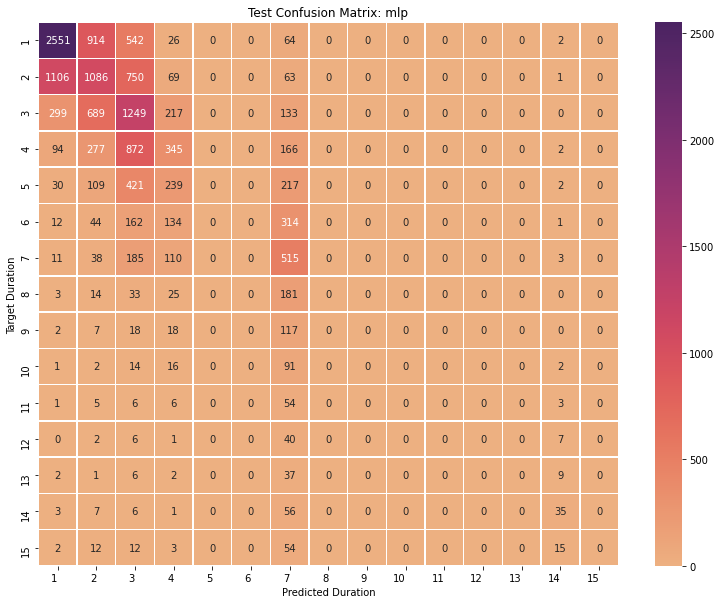

working on: tree


<Figure size 432x288 with 0 Axes>

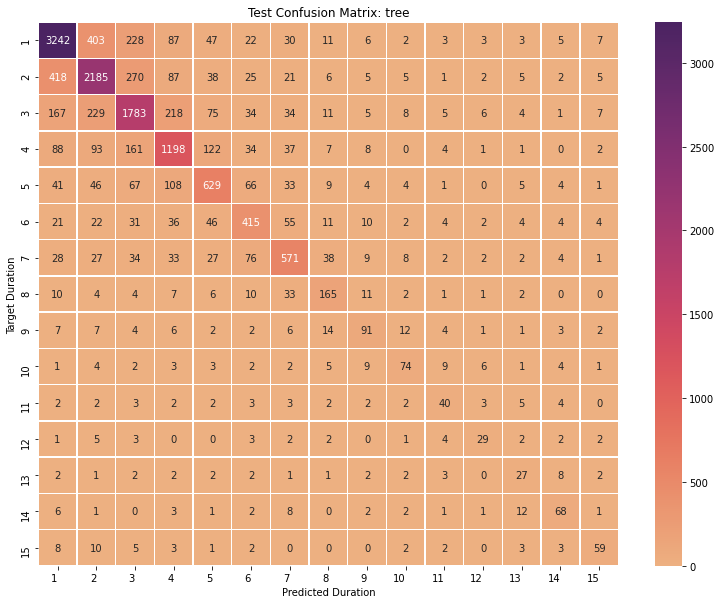

working on: svm


<Figure size 432x288 with 0 Axes>

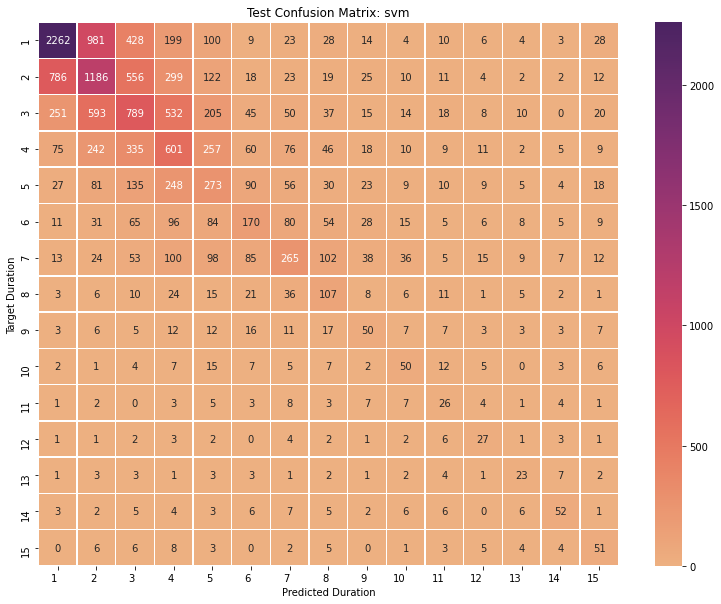

working on: knn


<Figure size 432x288 with 0 Axes>

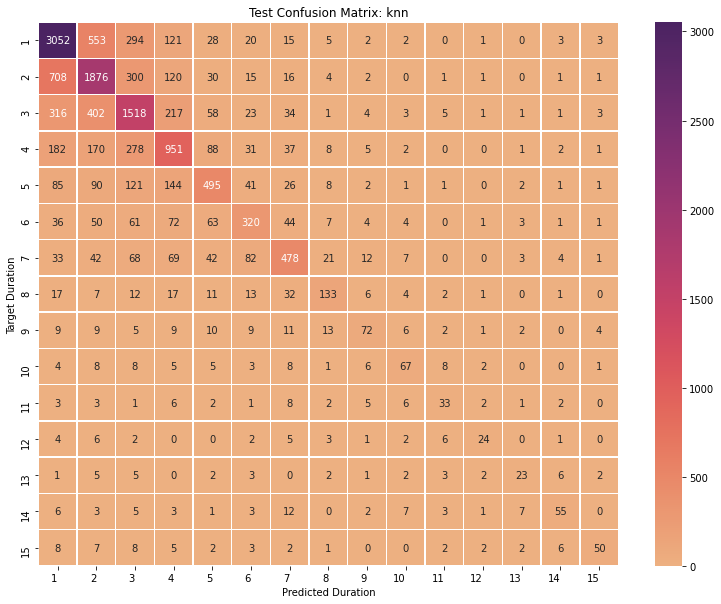

working on: forest


<Figure size 432x288 with 0 Axes>

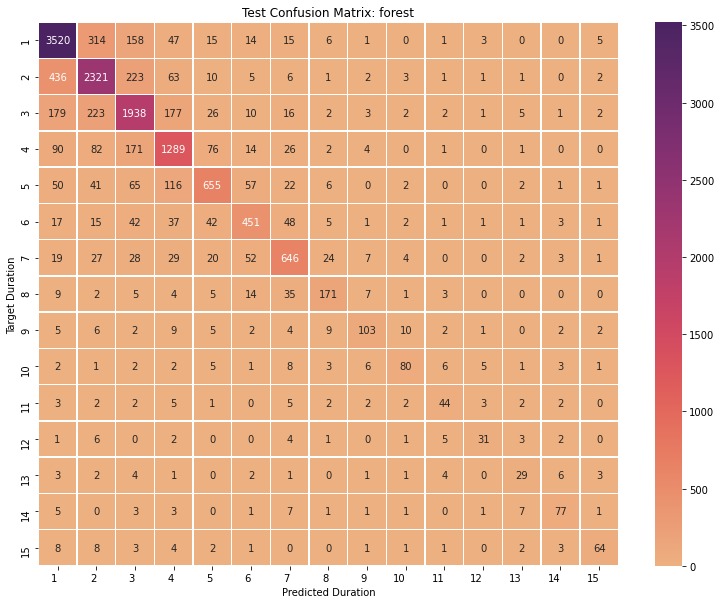

<Figure size 432x288 with 0 Axes>

In [ ]:
models = [mlp_clf, tree_clf, svm_clf, knn_clf, forest_clf ]
model_names = ["mlp", "tree", "svm", "knn", "forest"]
_, x_dev = preprocess(x_train, x_dev, y_train)

for model, name in zip(models, model_names):
  print('working on:', name)
  if name == "mlp":
    y_pred = np.argmax(model.predict(mlp_x_dev), axis=1) + 1
  else:
    y_pred = model.predict(mlp_x_dev)
  plot_cm(y_pred, y_dev, name)

### 3.4 Jensen -  Shannon distance

In [ ]:
models = [ mlp_clf, tree_clf, svm_clf, knn_clf, forest_clf ]
model_names = ["mlp","tree", "svm", "knn", "forest"]

for model,name in zip(models,model_names):
  if name == "mlp":
    y_pred = np.argmax(model.predict(x_dev), axis=1) + 1
  else:
    y_pred = model.predict(mlp_x_dev)

  dev_dist = np.bincount(y_dev.astype(int))
  pred_dist = np.bincount(y_pred.astype(int))
  print(name," Jensen shannon distance: ", jensenshannon(dev_dist, pred_dist))


### 3.5 Classfification Report

In [ ]:
models = [ mlp_clf, tree_clf, svm_clf, knn_clf, forest_clf ]
model_names = ["mlp","tree", "svm", "knn", "forest"]

for model,name in zip(models,model_names):
  if name == "mlp":
    y_pred = np.argmax(model.predict(mlp_x_dev), axis=1) + 1
  else:
    y_pred = model.predict(mlp_x_dev)

  print("Classification report - "+name+" : ")
  print(classification_report(y_true = y_dev, y_pred = y_pred))

Classification report - mlp : 
              precision    recall  f1-score   support

         1.0       0.61      0.65      0.63      4099
         2.0       0.33      0.39      0.36      3075
         3.0       0.30      0.41      0.34      2587
         4.0       0.28      0.20      0.23      1756
         5.0       0.00      0.00      0.00      1018
         6.0       0.00      0.00      0.00       667
         7.0       0.24      0.60      0.34       862
         8.0       0.00      0.00      0.00       256
         9.0       0.00      0.00      0.00       162
        10.0       0.00      0.00      0.00       126
        11.0       0.00      0.00      0.00        75
        12.0       0.00      0.00      0.00        56
        13.0       0.00      0.00      0.00        57
        14.0       0.41      0.31      0.36       108
        15.0       0.00      0.00      0.00        98

    accuracy                           0.39     15002
   macro avg       0.14      0.17      0.15     1

## 4.0 - Final model tuning and evaluation

### 4.1 Grid Search

In [ ]:
%%time
x_grid, _ = preprocess(x_train, x_train.iloc[:10], y_train)

In [ ]:
%%time
parameters = {'n_estimators': [10, 100, 200],
              'criterion': ['gini', 'entropy'],
              'max_depth': [10, 20, None]}

grid_clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), parameters, cv = 5, scoring = 'f1_weighted')
grid_clf.fit(x_grid, y_train)
print("Best parameters set found on development set:")
print()
print(grid_clf.best_params_, '\n', grid_clf.best_score_)

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 200} 
 0.7537561922476097
CPU times: user 29min 54s, sys: 23.9 s, total: 30min 17s
Wall time: 30min 22s


### 4.2 Benchmark

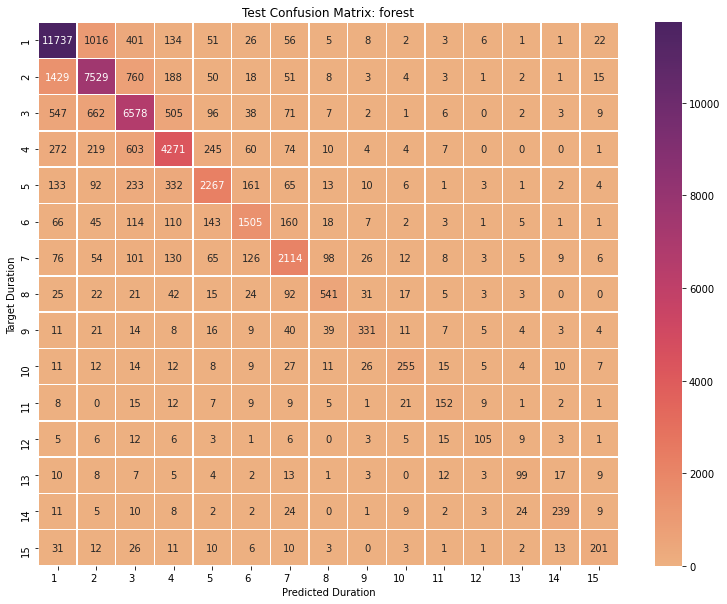


-------------------------------------------------
Classification report: 
              precision    recall  f1-score   support

         1.0       0.82      0.87      0.84     13469
         2.0       0.78      0.75      0.76     10062
         3.0       0.74      0.77      0.75      8527
         4.0       0.74      0.74      0.74      5770
         5.0       0.76      0.68      0.72      3323
         6.0       0.75      0.69      0.72      2181
         7.0       0.75      0.75      0.75      2833
         8.0       0.71      0.64      0.68       841
         9.0       0.73      0.63      0.68       523
        10.0       0.72      0.60      0.66       426
        11.0       0.63      0.60      0.62       252
        12.0       0.71      0.58      0.64       180
        13.0       0.61      0.51      0.56       193
        14.0       0.79      0.68      0.73       349
        15.0       0.69      0.61      0.65       330

    accuracy                           0.77     49259
   ma

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred = grid_clf.predict(x_test)


# confusion matrix

plot_cm(y_pred, y_test, 'forest')

print('\n-------------------------------------------------')

# Classification report

print("Classification report: ")
print(classification_report(y_true = y_test, y_pred = y_pred))

## 5.0 -  Result Explaination

In [ ]:
y_train_shap = y_train_shap.apply(lambda x: x if x<=7 else 8)
x_train_shap, _ = preprocess(x_train_shap, x_train.iloc[:10], y_train_shap)

model = RandomForestClassifier(class_weight='balanced')
# best parameters from grid search
# model is trained again since classes are segmented slightly differently
params = {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
model.set_params(**params)
model.fir(x_train_shap, y_train_shap)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_shap)

shap.initjs()

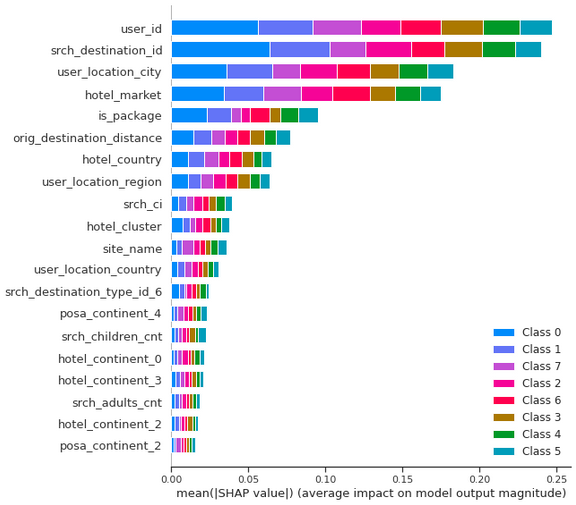

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, x_train_shap, plot_type="bar")

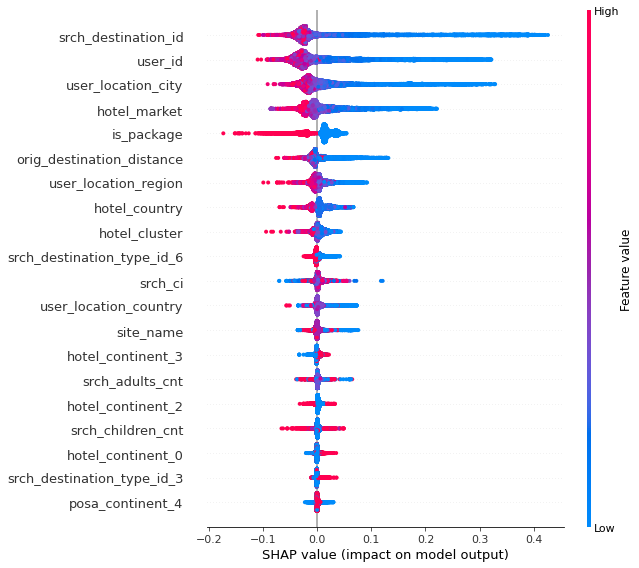

In [ ]:
# force plot for 1 day
shap.summary_plot(shap_values[0], x_train_shap)

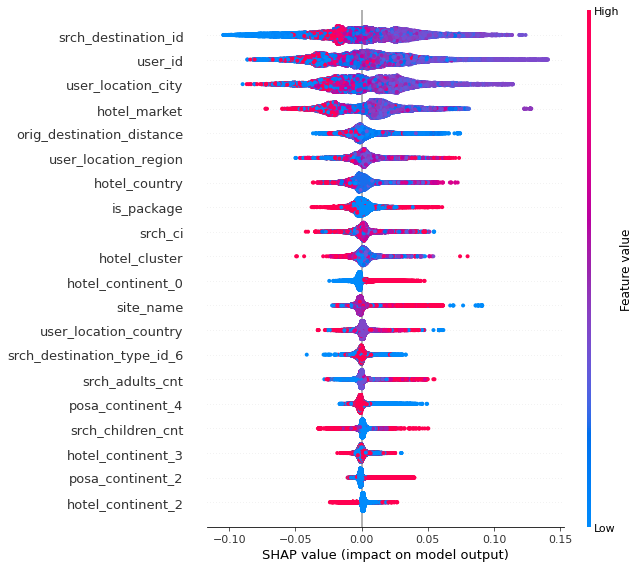

In [ ]:
# force plot for 3 days
shap.summary_plot(shap_values[2], x_train_shap)

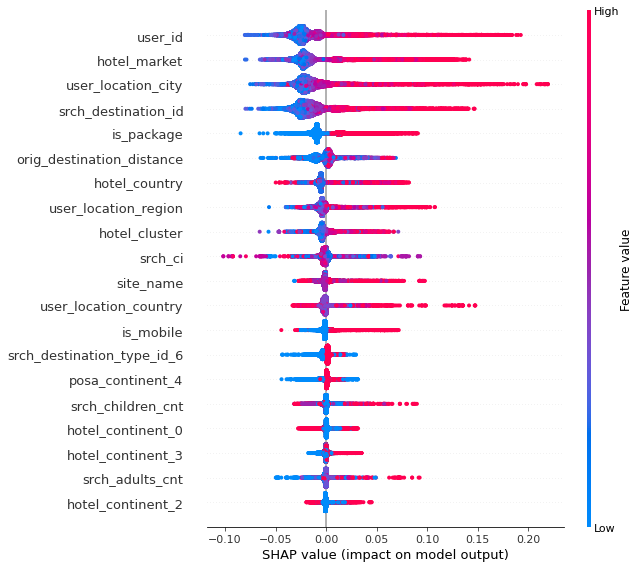

In [ ]:
# force plot for 7 days
shap.summary_plot(shap_values[6], x_train_shap)

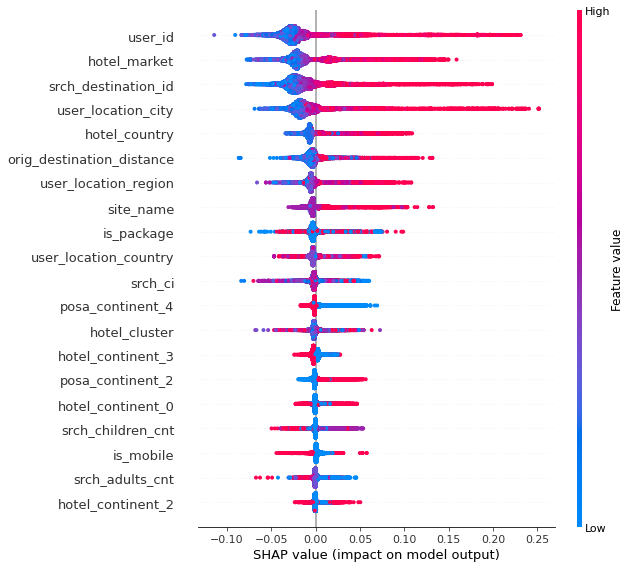

In [ ]:
# force plot for more than 7 days
shap.summary_plot(shap_values[-1], x_train_shap)